In [2]:
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import keras
from keras import losses, metrics, layers, ops

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
train_set_df = train_df[['agent1', 'agent2', 'EnglishRules', 'LudRules']]

In [5]:
lud_preprocessor = layers.TextVectorization(
    vocabulary='ludii_tokens.dic',
    standardize='strip_punctuation'
)

eng_preprocessor = layers.TextVectorization(
    vocabulary='eng_tokens.dic'
)

max_eng = 0
max_lud = 0

eng_uniques = train_set_df['EnglishRules'].unique()

for engrul in tqdm(eng_uniques):
    eng_vector = eng_preprocessor(engrul)
    max_eng = max(max_eng, eng_vector.shape[0])

print(max_eng)


100%|██████████| 1328/1328 [00:05<00:00, 260.12it/s]

858


In [6]:
lud_uniques = train_set_df['LudRules'].unique()

EQPMNT_RE = r'\(equipment'
RULESTRIP_RE = r'[^a-zA-Z\(\)\{\}]'

for rule in lud_uniques:
    start = re.search(EQPMNT_RE, rule).span()[0]
    pure_rule = rule[start:]
    pure_rule = re.sub(RULESTRIP_RE, ' ', pure_rule)
    lud_vector = lud_preprocessor(pure_rule)
    max_lud = max(max_lud, lud_vector.shape[0])

print(max_lud)

23613


In [7]:
agent1_uniques = train_set_df['agent1'].unique()
agent2_uniques = train_set_df['agent2'].unique()

set(agent1_uniques) >= set(agent2_uniques)

code_agent = {}
agent_code = {}

for id, agent in enumerate(agent1_uniques):
    code_agent[id] = agent
    agent_code[agent] = id


eng_vector.shape=(900,)

lud_vector.shape=(23700,)

agents_to_categorical.shape=(144)

In [8]:
# 900+23700+144 = 24744
# defining input shape and input data distribution

agents_len = 144
engvector_len = 900
ludvector_len = 23700

enter = layers.Input(shape=(24744,))
agent_input_layer = layers.Input(shape=(agents_len,))
agent_input_data = ops.slice(enter, (0,), (agents_len,))

engrul_input_data = ops.slice(enter, (agents_len,), (engvector_len,))

ludrul_input_data = ops.slice(enter, (agents_len+engvector_len,), (ludvector_len,))

In [27]:
# English rules LSTM features extractor.
# 
# Train set contains 587 preextracted features.
# Let`s assume that game rule contains these features and ather that describes 
# Number of these features is unknown and needs to be discovered
# presume that total amount of fetures, that are important for game result prediction is not less then double amount 
# of preextracted features and to be 1200

FEATURES_NUM = 1200
ENG_VECTOR_DIM = 512
LUD_VECTOR_DIM = 768


In [28]:
# EngRule LSTM

engrul_input_layer = layers.Input(shape=(engvector_len,))
eng_emb = layers.Embedding(input_dim=3692, output_dim=ENG_VECTOR_DIM)(engrul_input_layer)
eng_x = layers.Bidirectional(layers.LSTM(ENG_VECTOR_DIM, return_sequences=True))(eng_emb)
eng_x = layers.Bidirectional(layers.LSTM(ENG_VECTOR_DIM))(eng_x)
eng_out = layers.Dense(FEATURES_NUM, activation='relu')(eng_x)

# model = keras.Model(inputs=[enter], outputs=[eng_out])

# model.summary()

In [29]:
# LudRule LSTM

ludrul_input_layer = layers.Input(shape=(ludvector_len,))
lud_emb = layers.Embedding(input_dim=1240, output_dim=LUD_VECTOR_DIM)(ludrul_input_layer)
lud_x = layers.Bidirectional(layers.LSTM(LUD_VECTOR_DIM, return_sequences=True))(lud_emb)
lud_x = layers.Bidirectional(layers.LSTM(LUD_VECTOR_DIM))(lud_x)
lud_out = layers.Dense(FEATURES_NUM, activation='relu')(lud_x)


In [30]:
assemble = layers.Concatenate(axis=1)([agent_input_layer, eng_out, lud_out])
x = layers.Dense(1200, activation='relu')(assemble)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='tanh')(x)

model = keras.Model(inputs=[agent_input_layer, engrul_input_layer, ludrul_input_layer],
                    outputs=[out])


In [31]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 900)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 23700)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 900, 512)  │  1,890,304 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 23700,     │    952,320 │ input_layer_9[0]… │
│ (Embedding)         │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 900, 1024) │  4,198,400 │ embedding_6[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 23700,     │  9,443,328 │ embedding_7[0][0] │
│ (Bidirectional)     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 1024)      │  6,295,552 │ bidirectional_12… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 1536)      │ 14,161,920 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 144)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1200)      │  1,230,000 │ bidirectional_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1200)      │  1,844,400 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 2544)      │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ dense_22[0][0],   │
│                     │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1200)      │  3,054,000 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 512)       │    614,912 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │    131,328 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1)         │        257 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,816,721 (167.15 MB)

 Trainable params: 43,816,721 (167.15 MB)

 Non-trainable params: 0 (0.00 B)

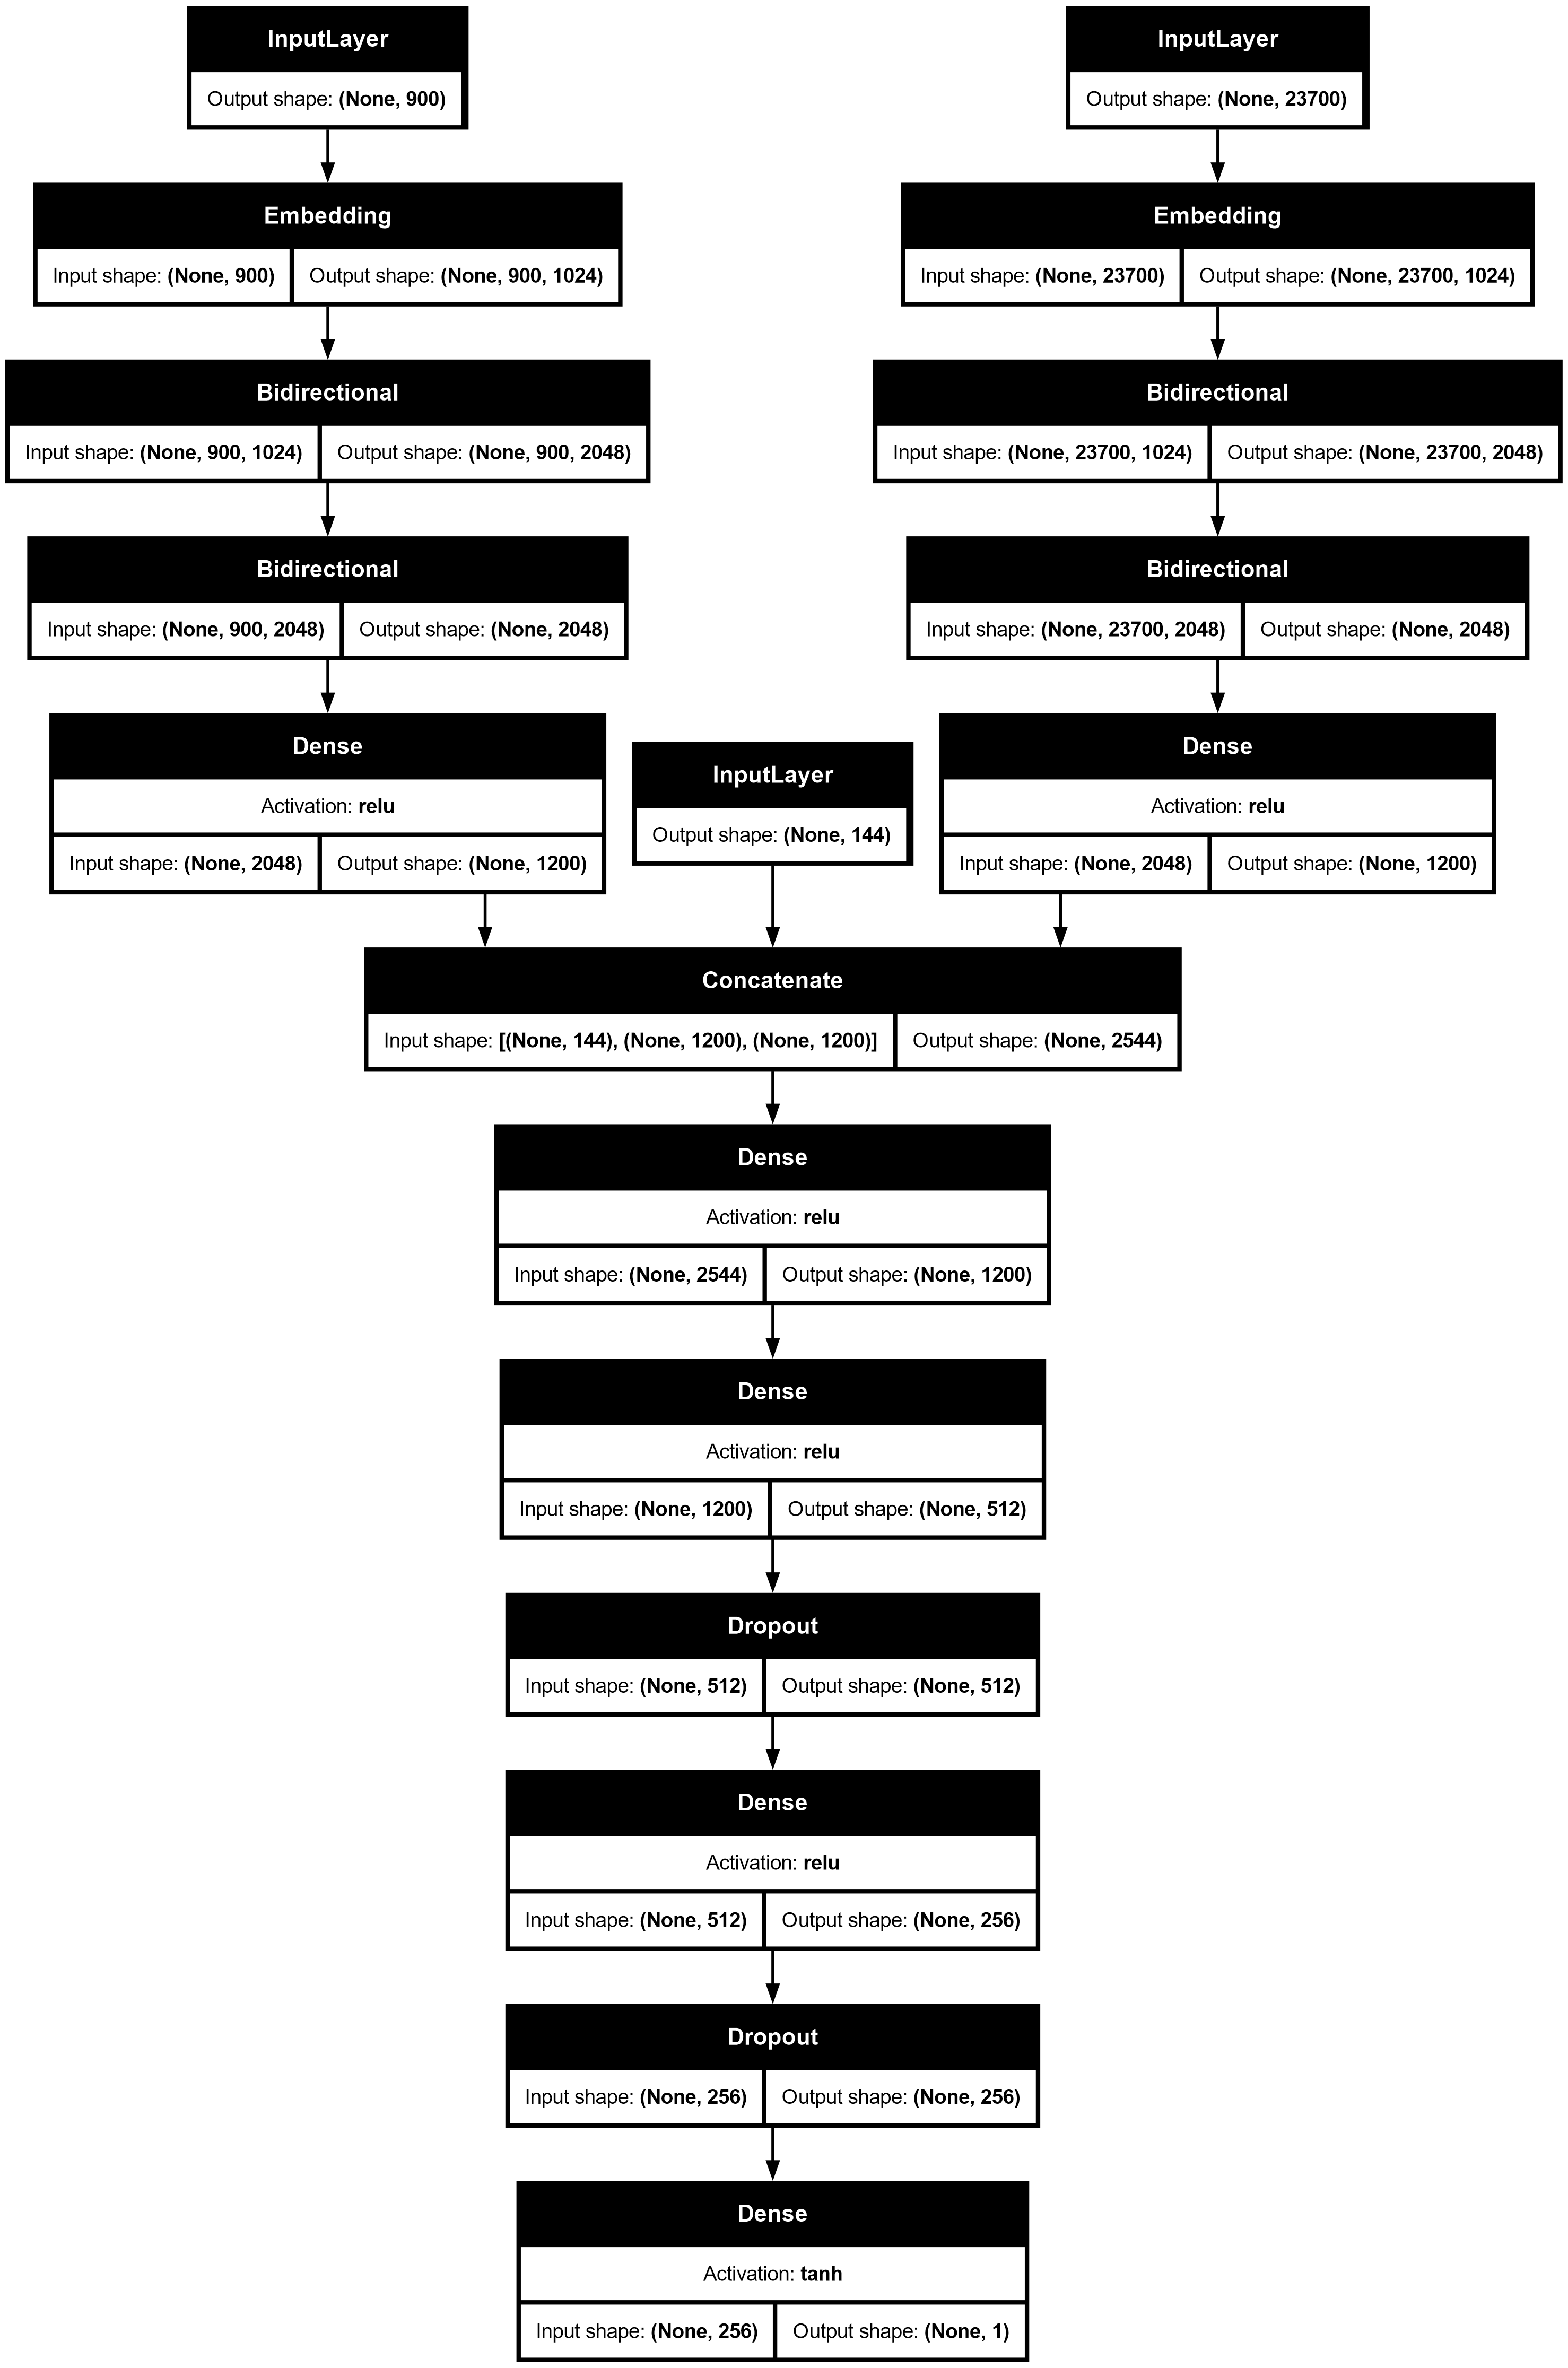

In [21]:
keras.utils.plot_model(model,
                       show_shapes=True,
                       expand_nested=True,
                       show_layer_activations=True)

## DataGenerator

In [ ]:
#  
#
#

class GameDataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, dataframe, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.df = dataframe
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_IDs))

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, batch_num):
          # Generate indexes of the batch
        indexes = self.indexes[batch_num*self.batch_size:(batch_num+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_ends(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            row = self.df.loc[ID]
            study_id, series_id, instance_num, _ = row
            
            label_encoded = label_code[labels_dict[ID]]
            y.append(keras.utils.to_categorical(label_encoded, self.n_classes))
            
            img = pydicom.dcmread(f'train_images/{study_id}/{series_id}/{instance_num}.dcm').pixel_array

            if img.shape[0] != img.shape[1]:
                img = pad_2_square(img)  
            if img.shape[0] != self.dim[0]:
                img = uniform_size(img, self.dim[0])
            img = normalize(img)
            img = np.reshape(img, (self.dim[0], self.dim[0], 1))

            X[i] = img

        return X, np.array(y)